<IPython.core.display.Javascript object>


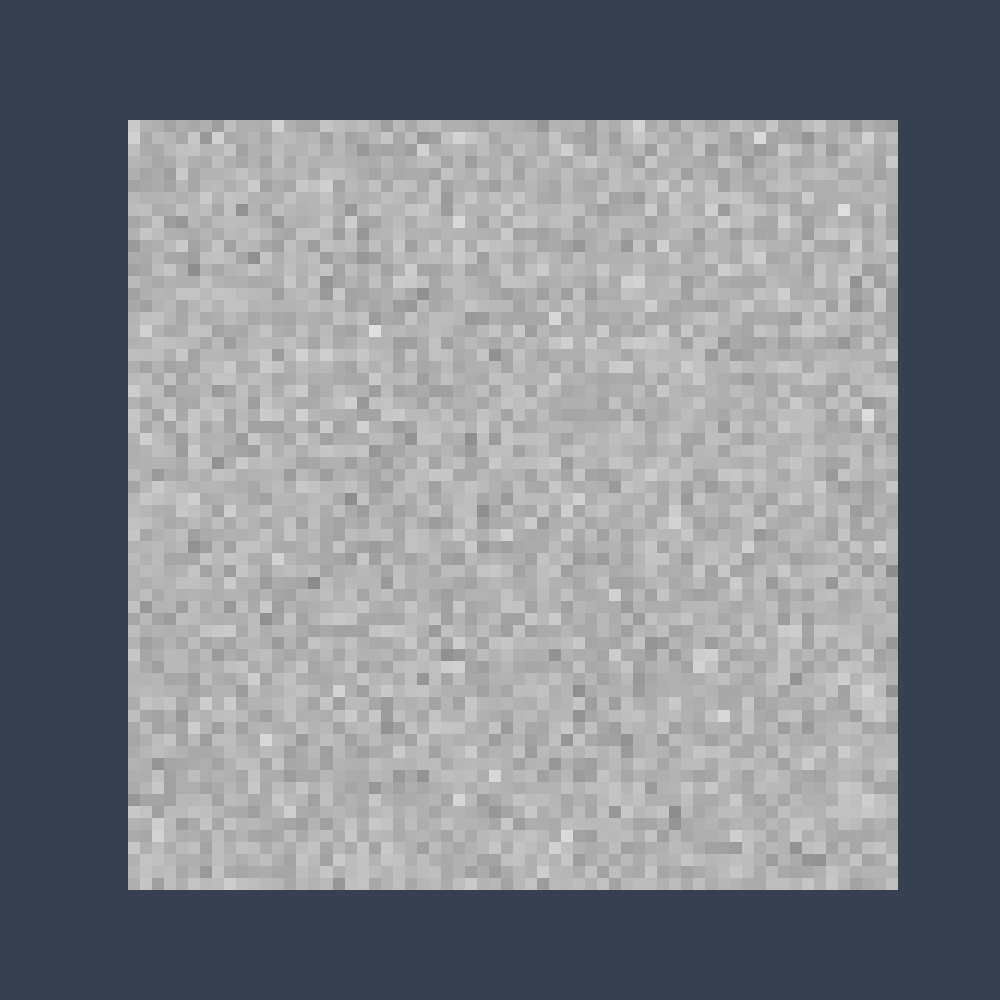

<IPython.core.display.Javascript object>


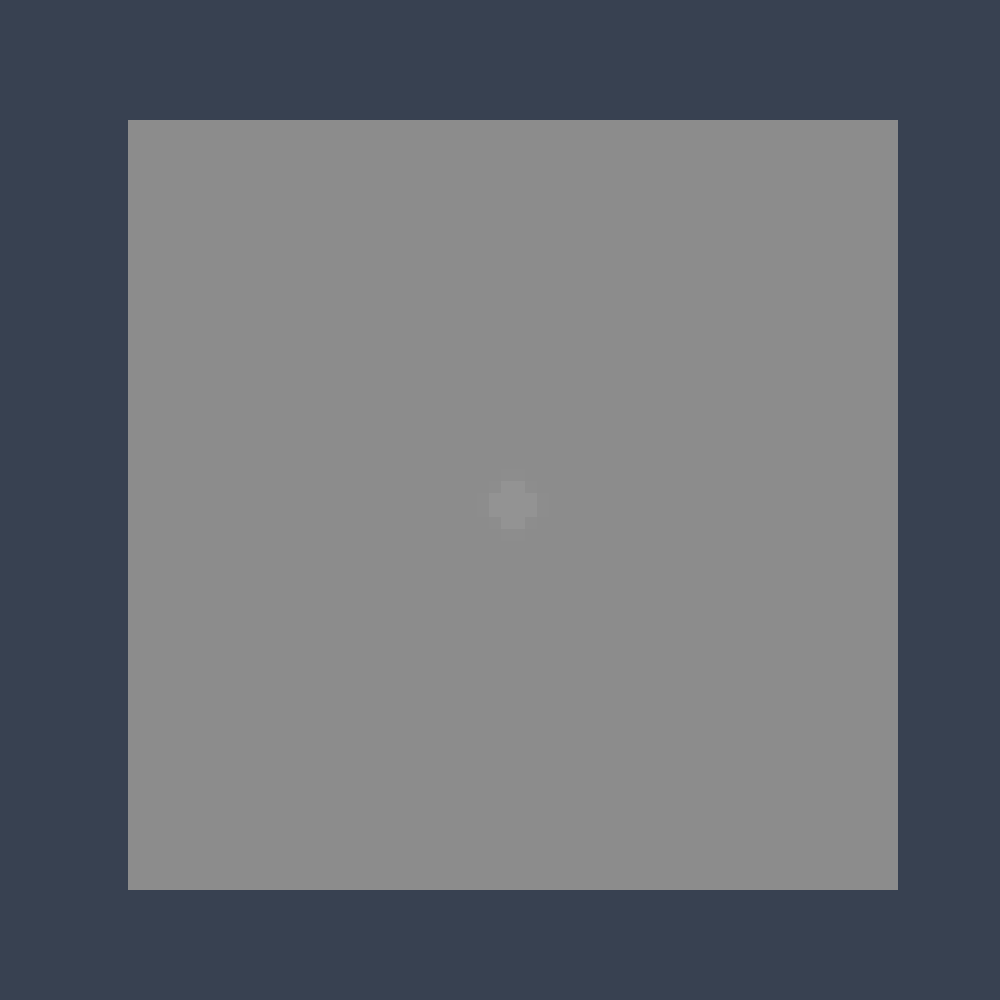

<IPython.core.display.Javascript object>


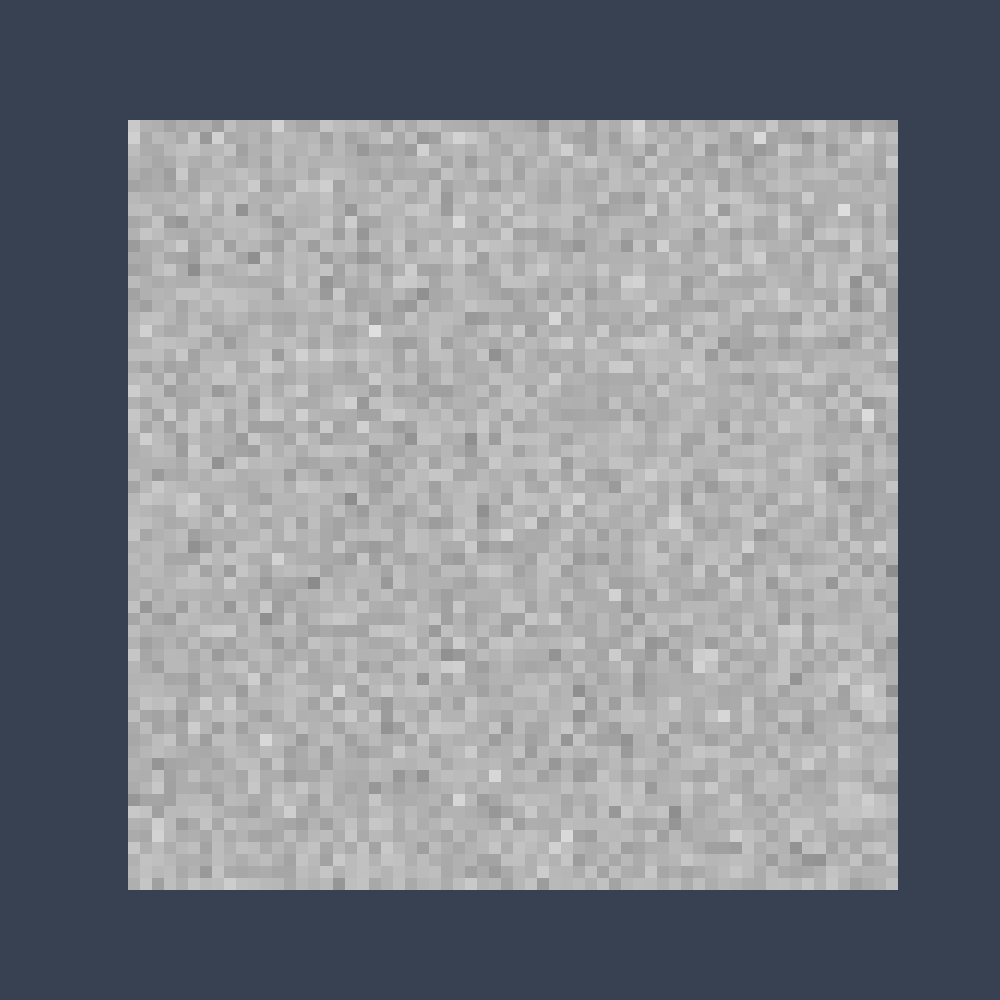

In [1]:
%matplotlib notebook

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import scipy.ndimage as snd
import numpy as np

# Set plot theme
jtplot.style()

# Settings
signal_intensity = 8 # set signal intensity
background_intensity = 140 # set background intensity
mean_noise = 0
var_noise = 150 # set var noise 1
gaussian_sigma = 0.5 # set sd of gaussian kernel
num_images = 4400 # number of images to create
image_size = 64
obj_dim1 = [30,34]
obj_dim2 = [31,33]
train_idx = 4200
val_idx = 4400

# Create list to store noise images
noise = []

# Create noise images
for n in range(num_images):
    # Create measurement noise
    mean_noise = np.random.rand()*50
    var_noise = np.random.rand()*250
    noise.append(np.random.normal(mean_noise,var_noise**(0.5),(image_size,image_size)))
    
# Create background image
background = np.ones((image_size,image_size))*background_intensity
background_gauss = snd.filters.gaussian_filter(background,gaussian_sigma)

# Create signal image
signal = np.zeros((image_size,image_size))
signal[obj_dim1[0]:obj_dim1[1],obj_dim2[0]:obj_dim2[1]] = signal_intensity
signal[obj_dim2[0]:obj_dim2[1],obj_dim1[0]:obj_dim1[1]] = signal_intensity
signal_gauss = snd.filters.gaussian_filter(signal+background,gaussian_sigma)

# Combine background and signal
signal_absent = [background_gauss+nse for nse in noise]

# Combine signal + background + noise
signal_present = [signal_gauss+nse for nse in noise]

# Display Images (from 1st sample)

# signal absent image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(signal_absent[0],cmap='gray',vmin=0,vmax=255)

# signal image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(signal_gauss,cmap='gray',vmin=0,vmax=255)

# signal present image
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(signal_present[0],cmap='gray',vmin=0,vmax=255)
plt.show()

# plot images
plt.show()

In [2]:
from functools import reduce

# split train/val set
train_signal_absent = signal_absent[0:train_idx]
train_signal_present = signal_present[0:train_idx]
val_signal_absent = signal_absent[train_idx:val_idx]
val_signal_present = signal_present[train_idx:val_idx]

# Generate average images for signal present/signal absent
avg_signal_absent = reduce(lambda x,y:x+y, train_signal_absent)/num_images
avg_signal_present = reduce(lambda x,y:x+y, train_signal_present)/num_images

# # avg noise image
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(avg_signal_absent,cmap='gray',vmin=0,vmax=255)

# # avg signal + noise image
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(avg_signal_present,cmap='gray',vmin=0,vmax=255)

# plot images
# plt.show()

# flatten arrays
avg_signal_absent_array = avg_signal_absent.flatten()
avg_signal_present_array = avg_signal_present.flatten()
val_signal_absent = np.transpose(np.vstack([n.flatten() for n in val_signal_absent]))
val_signal_present = np.transpose(np.vstack([n.flatten() for n in val_signal_present]))

In [3]:
# combine validation images
data_array = np.hstack((val_signal_absent,val_signal_present))

# # calculate covariance/inverse covariance matrix # only for correlated gaussian noise
# covariance = np.cov(noise_array)
# icov = np.linalg.inv(covariance)

# calculate diffence of avg 2 classes
avg_t = avg_signal_present_array-avg_signal_absent_array

# calculate test statistic
#l_pw = np.matmul(np.matmul(avg_t,icov),data_array)
l_pw = np.matmul(avg_t,data_array)

AUC: 0.6071500000000001


<IPython.core.display.Javascript object>


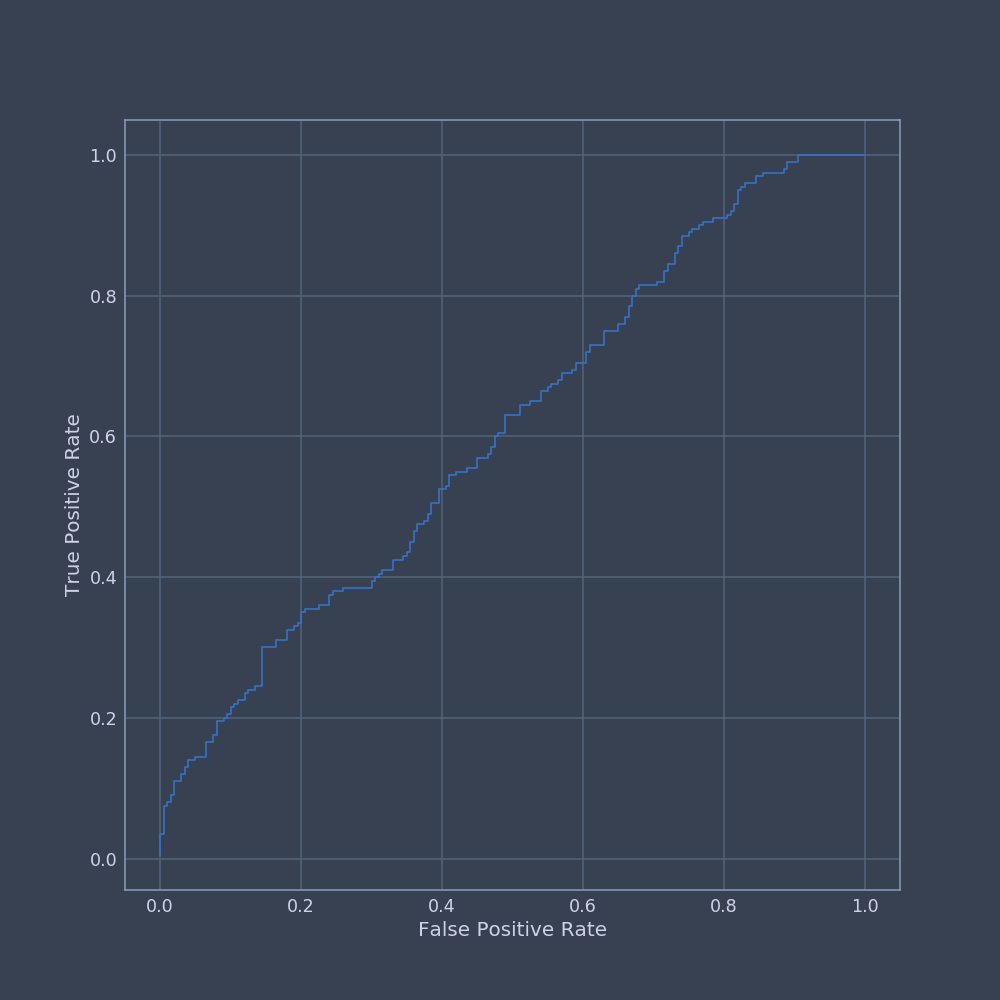

In [4]:
from sklearn.metrics import roc_auc_score,roc_curve

# print performance
img_cls = np.array([0]*(val_idx-train_idx) + [1]*(val_idx-train_idx))
[fpr,tpr,threshold] = roc_curve(img_cls,l_pw)
print("AUC: {}".format(roc_auc_score(img_cls,l_pw)))
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()